# Store netCDF output

In [1]:
import matplotlib.pyplot as plt
import netCDF4
from typhon import plots

import konrad


plots.styles.use("typhon")

During the configuration of an RCE simulation we can specify an output netCDF file.
Konrad will create the file and store a snapshot of the instantaneous model state at a given output frequency.

In [2]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)

rce = konrad.RCE(
    atmosphere,
    surface=konrad.surface.FixedTemperature(temperature=288.),  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration='100d',  # Set maximum runtime.
    outfile="my_rce_output.nc",  # Specifiy the output file
    writeevery="5d",  # Set the output frequency
)
rce.run()

## Read and visualize model output

After the run has finished, we can use the `netCDF4` package to read the data again.
Here, we plot the temporal evolution of the temperature profile from the inital US standard atmosphere towards the equilibrium RCE state.

Text(0, 0.5, '$p$ / hPa')

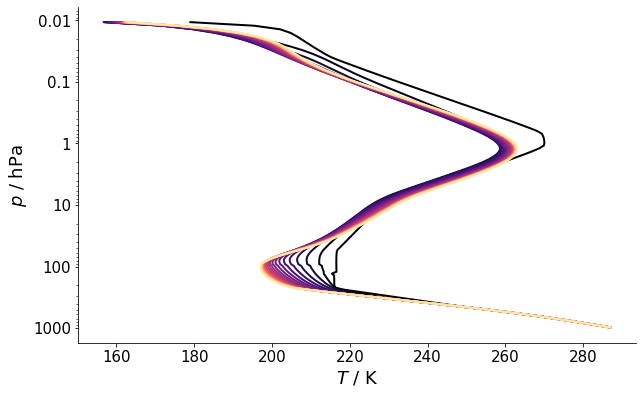

In [3]:
with netCDF4.Dataset("my_rce_output.nc", "r") as root:
    p = root["plev"][:]
    T = root["atmosphere/T"][:]

sm = plt.cm.ScalarMappable(norm=plt.Normalize(0, T.shape[0]), cmap="magma")

fig, ax = plt.subplots()
for i, temp in enumerate(T):
    plots.profile_p_log(p, temp, linestyle="solid", color=sm.to_rgba(i))
ax.set_xlabel(r"$T$ / K")
ax.set_ylabel(r"$p$ / hPa")

## Restart from a stored model state

It is possible to initialize the atmospheric and surface state from a previous run.

In [4]:
ncfile = "my_rce_output.nc"
atmosphere = konrad.atmosphere.Atmosphere.from_netcdf(ncfile)
surface = konrad.surface.FixedTemperature.from_netcdf(ncfile)

This allows the user to _spin-up_ the model to a reference state before performing a perturbation.
For example, one can double the CO2 concentration in an otherwise equilibrated atmosphere to observe the stratospheric temperature adjustment.

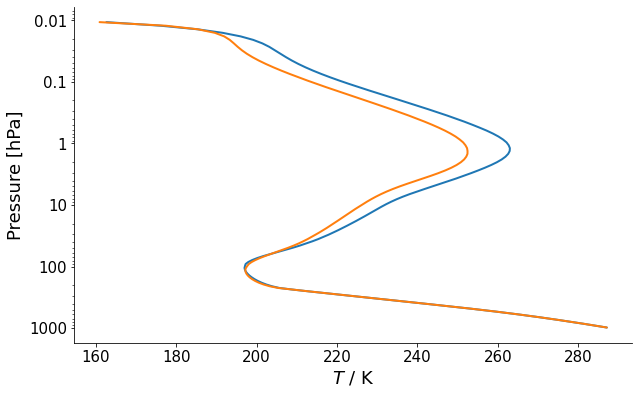

In [5]:
# Plot reference state
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere["plev"], atmosphere["T"][-1])
ax.set_xlabel(r"$T$ / K")
ax.set_ylabel(r"$p$ / hPa")

atmosphere["CO2"][:] *= 2. # Double the CO2 concentration

rce = konrad.RCE(
    atmosphere,
    surface=surface,
    timestep='12h',  # Set timestep in model time.
    max_duration='100d',  # Set maximum runtime.
)
rce.run()

# Plot adjusted state
plots.profile_p_log(atmosphere["plev"], atmosphere["T"][-1])